<a href="https://colab.research.google.com/github/KiraGarvinLerman/ColabBackups/blob/main/Ologies_Topics_vs_Google_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

##Objective

**Description:** Ologies is a popular podcast hosted by Alie Ward, where she interviews experts ("-ologists") in various fields to explore fascinating and often obscure topics. Each episode delves into a different "ology," making science and learning accessible and engaging for a broad audience.


*Ologies' official description as of Oct. 2024:*
> Volcanoes. Trees. Drunk butterflies. Mars missions. Slug sex. Death. Beauty standards. Anxiety busters. Beer science. Bee drama. Take away a pocket full of science knowledge and charming, bizarre stories about what fuels these professional -ologists' obsessions. Humorist and science correspondent Alie Ward asks smart people stupid questions and the answers might change your life.


**Hypothesis:** Exposure to novel topics through Ologies episodes will trigger increased online searches related to those topics. Listeners, intrigued by the information presented, are likely to seek further knowledge and explore the subject in more detail through provided links and search engines like Google.

## Approach

1. **Scrape Ologies Episodes:**
   - Use [BeautifulSoup](https://colab.research.google.com/github/Tanu-N-Prabhu/Python/blob/master/Google_Trends_API.ipynb) to extract details about the episodes of the Ologies podcast. This includes episode titles, date, and the keywords covered.

2. **Gather Search Trend Data:**
   - Use [Pytrends](https://colab.research.google.com/github/Tanu-N-Prabhu/Python/blob/master/Google_Trends_API.ipynb) to collect data on search trends related to the topics discussed in the Ologies episodes.

3. **Analyze Correlation:**
   - Compare the trends in the search data with the topics covered in the Ologies podcast episodes. Look for patterns or correlations to determine if there’s a relationship between the podcast topics and the public’s interest as reflected in search data.

   [Colab Link](https://colab.research.google.com/drive/1kFqjjOJCmk22Q_ts3Q1mDP-HW9wCuFtT?usp=sharing)
   [GitHub Repo](https://github.com/KiraGarvinLerman/ColabBackups.git)

# Web Scraping with `requests` and `BeautifulSoup`

Using `requests` and `BeautifulSoup` to access and scrape the content of [Ologies' Categorical Information](https://www.alieward.com/ologies), and [Podcast Feed](https://feeds.simplecast.com/FO6kxYGj).

In [88]:
# Import Beautiful Soup and other tools
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime
import re

%matplotlib inline


## Determine Sources & Collection Points

###Ologies Website - Categories

In [89]:
# Ologies' Website
ologies_url = 'https://www.alieward.com/ologies-by-topic'

#Confirm no scraping errors and retrieve data from URL
ologies_response = requests.get(ologies_url)
print(ologies_response)

# Parse the whole HTML page using BeautifulSoup
ologies_soup = BeautifulSoup(ologies_response.text, 'html')

# Confirm correct page is pulling
ologies_soup.title.string

<Response [200]>


'Ologies by Topic — alie ward'

###Ologies Podcast Feed

In [90]:
# Ologies' Feed
ologies_feed = 'https://feeds.simplecast.com/FO6kxYGj'

#Confirm no scraping errors and retrieve data from URL
feed_response = requests.get(ologies_feed)
print(feed_response)

# Parse the whole XML file using BeautifulSoup
feed_soup = BeautifulSoup(feed_response.content, features="xml")

# Confirm correct file is pulling
feed_soup.title.string

<Response [200]>


'Ologies with Alie Ward'

## Collect Data

###Collect Category Information

In [91]:
# Check html labeling and determine structure:
# * Category: "a" class = "archive-group-name-link"
#  * Category's Episodes: "ul" class="archive-item-list"
#    * Episode: "li" class="archive-item archive-item--show-date"
#      * Date Sort: "span" class="archive-item-date-before"
#      * Episode Name: a class="archive-item-link"
#      * Episode Latest Air-date: "span" class="archive-item-date-after"

# Confirm accurate parsing:
category_data_outer = ologies_soup.find('div', id = "block-yui_3_17_2_1_1691591227690_3212") # For full project

category_data_inner = category_data_outer.find('a', class_ = "archive-group-name-link").get_text().strip() # For testing parsing
episode_data_inner = category_data_outer.find('a', class_ = "archive-item-link").get_text().strip() # For testing parsing
print(category_data_inner+":", episode_data_inner) # For testing parsing

Animals: Tardigradology (TINY SEMI-INDESTRUCTIBLE WATER BEAR MOSS PIGLET CREATURES CALLED TARDIGRADES) with Dr. Paul Bartels


In [92]:
# Check if episodes are listed in multiple categories
episodes_data_inner = category_data_outer.find_all('a', class_ = "archive-item-link")# Pull full list
seen = set()
dupes = [x.get_text().strip() for x in episodes_data_inner if x in seen or seen.add(x)] # Create list of duplicates
print(len(set(dupes)), "episodes are duplicated:")
for dupe in set(dupes):
  print(dupe)

9 episodes are duplicated:
Molecular Biology (PROTEINS + SCIENCE COMMUNICATION) with Raven “The Science Maven” Baxter
Coffeeology (YEP, COFFEE) with Peter Giuliano
Indigenous Cuisinology (NATIVE COOKING) with Mariah Gladstone of Indigikitchen
Scatology (POOP) with Dr. Rachel Santymire
Indigenous Fire Ecology (GOOD FIRE) with Dr. Amy Christianson
Futurology (THE FUTURE) with Rose Eveleth
Maritime Archaeology (SHIPWRECKS) with Chanelle Zaphiropoulos
Speech Pathology (TALKING DOGS... AND PEOPLE) with Christina Hunger
Foraging Ecology (EATING WILD PLANTS) with @BlackForager, Alexis Nikole Nelson


###Collect Podcast Feed Data

###Episodal Data
Some episodes have been re-aired to cover periods of time off, to honor someone passing, etc. Additionally, there are different types of episodes including updates, being made into a "Smology" (for kids), etc.

Thus, we will need:
* an ology reference table (e.g., -ology, -ologist(s))
* a reference table for total airings of an ology (e.g. -ology, airdate, episode type)

####Parsing data from XML file

In [93]:
# Check XML labeling and determine structure:

  # <item>
    # <guid isPermaLink="false">--longID--</guid>
    # <title>Ology (COMMON NAME) [Encore, Part, etc.] with [-ologist(s)]</title>
    # <description>
      # <![CDATA[
          #<p>[Official description]</p>
          #<p>[More about the -ologist(s)]</p>
          #<p>Donations went to the [one or more charities with links]</p>
          #<p><a href="https://www.alieward.com/ologies/[ology]">More episode sources and links</a></p>
          #<p>Other episodes you may enjoy: <a href="https://www.alieward.com/ologies/[ology1]">Ology (NAME)</a>, etc.</p>
          #other <p>s that appear on every episode
    # </description>
    # <pubDate>Wed, 9 Oct 2024 07:00:00 +0000</pubDate>
    # <author>--</author>
    # <link>--</link>
    # <content:encoded>[Official description]</content:encoded>
    # <enclosure length=[numbers = bytes] type="audio/mpeg" url="[long URL for episode file]/>
    # <itunes:title>Ology (COMMON NAME) [Encore, Part, etc.] with [-ologist(s)]</itunes:title>
    # <itunes:author>Alie Ward</itunes:author>
    # <itunes:duration>00:52:23</itunes:duration>
    # <itunes:summary>[Official description]</itunes:summary>
    # <itunes:subtitle>[Official description]</itunes:subtitle>
    # <itunes:explicit>[True/False]</itunes:explicit>
    # <itunes:episodeType>full</itunes:episodeType>
  # </item>

# Confirm accurate parsing:
episode_data_outer = feed_soup.find('item')
episode_ology_inner = episode_data_outer.find('title').get_text().strip().split(" (",1)[0].replace("Spesh Ep: ","")
episode_date_inner = episode_data_outer.find('pubDate').get_text().strip()
episode_date = datetime.strptime(episode_date_inner,"%a, %d %b %Y %H:%M:%S %z")
episode_summary = episode_data_outer.find('itunes:summary').get_text().strip()

print(episode_ology_inner, episode_date.date()) # For testing parsing
print(episode_summary)


Field Trip: I Take You to the Making of a Mural 2024-10-30
Folks, come with me. We’re hanging out under some train tracks late at night in Philadelphia doing street art. As the promised companion piece to our wonderful Modern Toichographology episode on murals and street art, this Field Trip takes us to where the action happens, chatting with several muralists as they work on their 17-foot paintings lining Front Street. You’ll meet UNAPXLXGETIQ, El Toro, and Iris Barbee Pendergrass a.k.a. These Pink Lips and learn about their favorite inspirations, methods to making their designs huge, how many Sharpies it takes to outline a building-sized painting, sticker vs. marker vs. paint, graphic and text mural designs, freehand, and most of all, how not to get caught doing illegal art. Onward.


####Confirm understanding of -ology duplicates within file

In [94]:
# Confirm there are no duplicates when looking by **title** within the feed
episodes_data_outer = feed_soup.find_all('item')
episodes_data_inner = [item.find('title').get_text() for item in episodes_data_outer]
episodes_ologies = [x.split(" (",1)[0].replace("Spesh Ep: ","") for x in episodes_data_inner]

seen1 = set()
dupes = [x for x in episodes_data_inner if x in seen1 or seen1.add(x)] # Create list of duplicates
print(len(set(dupes)), "duplicates found by title.")

#but that there are duplicates when looking by -ology
seen2 = set()
dupes = [x for x in episodes_ologies if x in seen2 or seen2.add(x)] # Create list of duplicates
print(len(set(dupes)), "Ologies have been aired more than one way.")


0 duplicates found by title.
51 Ologies have been aired more than one way.


#Organizing Data
Now that we have an understanding about the data, we can organize them into tables.

## Category Reference Table

In [95]:
# At the time of this note, 9 epsidodes appear under multiple categories.
#This will be a reference table for Categories that apply to the Ology.

#Pull category information into a pandas db

cat_data = []

for cat_id, cat in enumerate(category_data_outer.find_all('a', class_ = "archive-group-name-link"),1):
    category = cat.get_text().strip()
    for ep in cat.find_next_sibling('ul').find_all('a'):
      ology = ep.get_text().strip().split(" (",1)[0].replace("Spesh Ep: ","")
      cat_data.append({'CategoryID': cat_id, 'Category': category, 'Ology': ology})

cat_ref_df = pd.DataFrame(cat_data)

print(cat_ref_df)

     CategoryID        Category            Ology
0             1         Animals   Tardigradology
1             1         Animals    Ambystomology
2             1         Animals  Hydrochoerology
3             1         Animals       Lemurology
4             1         Animals     Road Ecology
..          ...             ...              ...
301          17  The Human Body       Trichology
302          17  The Human Body       Gynecology
303          17  The Human Body         Sexology
304          17  The Human Body       Hematology
305          17  The Human Body     Glycobiology

[306 rows x 3 columns]


##Episodal Table

In [96]:
# We determined that title names are unique, but that -ologies are not.

# We want to pull description information about that specific episode, and not notes that are included on every episode

# Function to pop list items based on a list of keywords
def pop_items_by_keywords(items, keywords):
    removed_items = []  # List to store removed items
    for item in items[:]:  # Iterate over a copy of the list to avoid modifying it while iterating
        if any(keyword.lower() in item.lower() for keyword in keywords):  # Check against all keywords
            removed_items.append(item)  # Add matched item to removed items
            items.remove(item)  # Remove the item from the original list

    return removed_items  # Return all removed items

# repeated information to exclude from our description:
keywords = ["Transcripts",
    "Patreon.com/ologies",
    "OlogiesMerch.com",
    "instagram.com/ologies",
    "instagram.com/alieward",
    "Sound editing by",
    "Theme song by",
    "Music by",
    "Music",
    "Smologies",
    "Made possible by work from",
    "Sponsors",
    "Sponsor",
    "Editing by",
    "Managing Director",
    "Scheduling Producer",
    "Production",
    "/production",
    "Website by"]

In [115]:
#We know that there are -ologies with multiple parts, encores, updates, etc. so we will need to categorize them as they air
def ep_type_with_regex(text, dictionary):
    """
    Determines the episode type based on the presence of keywords in the text.

    Args:
        text: The text to analyze (e.g., episode title).
        dictionary: A dictionary where keys are episode type keywords.

    Returns:
        The episode type if a keyword is found, otherwise "Normal".
    """

    for keyword, episode_type in dictionary.items():
        if re.search(keyword, text, re.IGNORECASE):
            return episode_type
    return "Normal"

#type dictionary
episode_types_regex = {
    r"\b(encore)\b": "Encore",
    r"\b(part\s*\d+)\b": "Multi-Part",
    r"\b(spesh|special|field\s*trip)\b": "Special"}

#encore type dictionary
encore_types_regex = {
    r"\b(memor(y|ial)|tribute|passed\s*away)\b": "Memorial",
    r"\b(update(d)?|revisited|revised)\b": "Updated",
}

In [116]:
#Pull episode feed information into a pandas db

ep_pub_data = []
for ep_id, ep in enumerate(reversed(episodes_data_outer),1):
    guid = ep.find('guid').get_text().strip()
    episode = ep.find('title').get_text().strip()
    ology = episode.split(" (",1)[0].replace("Spesh Ep: ","")
    date = ep.find('pubDate').get_text().strip()
    ep_date = datetime.strptime(date,"%a, %d %b %Y %H:%M:%S %z").date()
    summary = ep.find('itunes:summary').get_text().strip().replace('\n'," ")
    desc = ep.find('encoded').get_text().replace('</p>','').replace('\xa0','').strip()
    description = desc.split('<p>')[1:]
    description_cleaned = pop_items_by_keywords(description, keywords) #pop-out repeated information
    supplemental = pop_items_by_keywords(description, summary.split()[0:3]) #pop-out the summary repeat
    duration = ep.find('itunes:duration').get_text().strip()
    ep_duration = datetime.strptime(duration,"%H:%M:%S").time()
    air_type = ep_type_with_regex(episode, episode_types_regex)
    if air_type == "Encore":
      encore = ep_type_with_regex(summary,encore_types_regex)
    else:
      encore = "Original"
    ep_pub_data.append({'epID': ep_id, 'GUID': guid, 'Airdate': ep_date, 'Duration': ep_duration, 'Episode Type' : air_type, 'Encore' : encore, 'Ology': ology, 'Episode Title': episode, 'Summary': summary, 'Supplemental': description})

ep_pub_df = pd.DataFrame(ep_pub_data)
print(ep_pub_df)

     epID                                               GUID     Airdate  \
0       1  gid://art19-episode-locator/V0/5tejk-w8gjcz3mh...  2017-09-04   
1       2  gid://art19-episode-locator/V0/y1YkAIXjuZ-WshL...  2017-09-19   
2       3  gid://art19-episode-locator/V0/rBCXtd5byuspJ-B...  2017-09-26   
3       4  gid://art19-episode-locator/V0/d6F-1L64A-45qwM...  2017-10-04   
4       5  gid://art19-episode-locator/V0/jrRWx8UFHOjQL-n...  2017-10-10   
..    ...                                                ...         ...   
415   416               1baaf1be-5069-47f8-8465-74a8c81fa32a  2024-10-02   
416   417               e63f507a-d055-4199-b432-3fd8b84c5db9  2024-10-09   
417   418               4afe7366-5d92-4ed9-ab42-d73678e66b79  2024-10-17   
418   419               3f5602fc-35d4-4447-8392-12426979bb6b  2024-10-23   
419   420               68023b48-71d9-470e-a3ae-db690b2300e8  2024-10-30   

     Duration Episode Type    Encore  \
0    00:04:35       Normal  Original   
1    00

#Reviewing Data

Encore        Memorial  Normal  Original  Updated  All
Episode Type                                          
Encore               2      41         0        4   47
Multi-Part           0       0        48        0   48
Normal               0       0       312        0  312
Special              0       0        13        0   13
All                  2      41       373        4  420


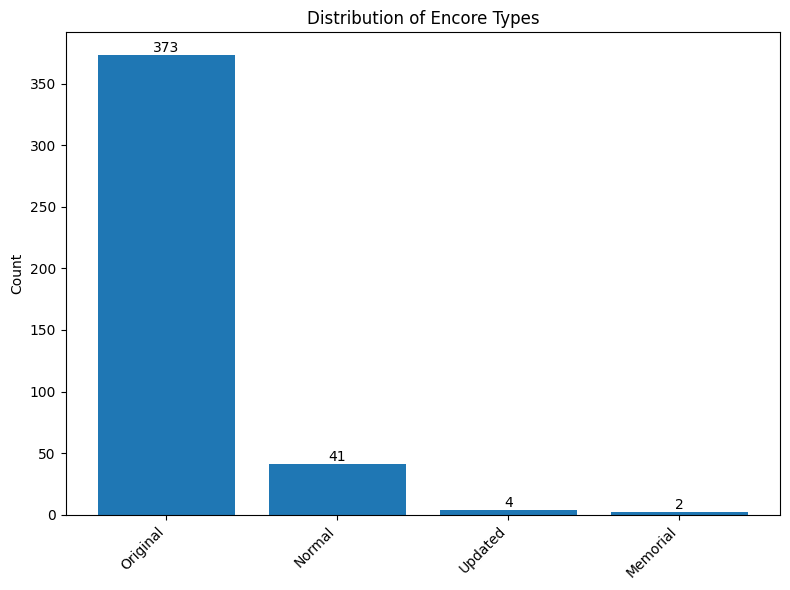

In [119]:
# let's look at how the encore data came out
encore_counts = ep_pub_df['Encore'].value_counts()

#table
episode_counts_table = pd.crosstab(ep_pub_df['Episode Type'], ep_pub_df['Encore'], margins = True)
print(episode_counts_table)

#chart
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(encore_counts.index, encore_counts.values)  # Create bar chart
plt.title('Distribution of Encore Types')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout for better spacing
for i, v in enumerate(encore_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()



#Next Steps

##Areas to continue exploration:
1.   Pull Ologists names into the DB
2.   Pull Google trends data on the ologists and ologies
3.   Explore trends around time of year, categories, etc.
4. Find a book sales database to see if there is a correlation there



##Future expansion
1. Generate an Ologies book list
2. Connect ology/ologists wikipedia pages
3. Pull information on charities donated to